###### $ Setup common moduls

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# Using assert to ensure compatible isntalled version
assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"
assert tf.__version__ >= "2.0"

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# For plot grayscale and RGB images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Deep Computer Vision Using Convolutional Neural Networks

Convolutional neural networks (CNNs) emarged form the tudy of the brain's visual corte, and they have been used in image recognation since 1080s. They power iamge search services, self-driving cars, automatix video classification systems, and more.

### The Architecture of the Visual Cortex
David H. Hubel and Torsten Wiesel performed a series of experiments on cats in 19581 and 19592 (and a few years later on monkeys3), giving crucial insights on the structure of the visual cortex (the authors received the Nobel Prize in Physiology or Medicine in 1981 for their work). In particular, they showed that many neurons in the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field (see Figure 14-1, in which the local receptive fields of five neurons are represented by dashed circles). The receptive fields of different neurons may overlap, and together they tile the whole visual field. Moreover, the authors showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations). They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons (in Figure 14-1, notice that each neuron is connected only to a few neurons from the previous layer). This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1401.png"/>

### Convolutional Layer

The most important building block of a CNN is the `convolutional layer`. Neurons is the first convolutional layer are not connected to every single pixel input image, but only to pixels in their fields. In turn, each neuron in  the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in the next hidden layer and so on. This hirarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognation.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1402.png" style="width: 600px;"/>

A neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows i to i + fh – 1, columns j to j + fw – 1, where fh and fw are the height and width of the receptive field. In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called zero padding.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1403.png" style="width: 600px;"/>

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. This dramatically reduces the model’s computational complexity. The shift from one receptive field to the next is called the stride. In the diagram, a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same in both directions, but it does not have to be so). A neuron located in row i, column j in the upper layer is connected to the outputs of the neurons in the previous layer located in rows i × sh to i × sh + fh – 1, columns j × sw to j × sw + fw – 1, where sh and sw are the vertical and horizontal strides.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1404.png" style="width: 600px;"/>

### Filters

A neuron's weights can be represented as a small image the size receptive field. For example, image below show two possible sets of weights, called filters (or convolution kernels). The first one is represented as a black square with a vertical white line in the middle( it is a 7 x 7 matrix full of 0s except for central column, which is full of 1s); neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the cental horizontal line.

Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image, the layer will output the to-left image.Notice that the vertical white lines get enhanced while the rest gets blurred. Similarly, the upper-right image is what you get if all neurons use the same horizontal line filter; notice that the horizontal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a `feature map`, which highlights the areas in an image that activate the filter the most. Of course you do not have to define the filters manually: instead, during training the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.
 
<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1405.png" style="width: 600px;"/>

### Stacking Multiple Fature Maps

up to now, for simplicity, I have represented the output of each convolutional layer as a 2D layer, but in reality a convolutional layer has multiple filters (you decide how many), and it outputs one feature map per filter, so it is more accurately represented in 3D. To do so, it has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the sama weights and bias term). However, neuron in defferent feature maps use different parameters. A neuron's receptive field is the sama as described earlier, but it extends across all the previous layers feature amap. In short, a convolutional layer simultaneously applied multiple trainable filters to its inputs, making it capable for detecting multiple fetures anywhere in its inputs.

Moreover, input images are also composed of multiple sublayers: one per color channel.there are typically three: red, green, and blue (RGB). Grayscale images have just one channel. but some images may have much more, for example, satellite images tha capture extra light frequences (such as infrared).

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1406.png" style="width: 600px;"/>

Specifically, a neuron located in row *i*, column *j* of the feature map *k* in a given convolutional layer *l* is connected to the outputs of the neurons in the previous layer *l* – 1, located in rows *i × sh to i × sh + fh – 1* and columns *j × sw to j × sw + fw – 1*, across all feature maps (in layer *l* – 1). Note that all neurons located in the same row *i* and column *j* but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

Below equation summarizes the preceding explanations in one big mathematical equation: it shows how to compute the output of given neuron in a convolutional layer. It is a bit ugly due to all the different indices, but all it does is calculate the weighted sum of all the iputs, plus the bias term.

<img src="https://user-images.githubusercontent.com/38347258/60491396-e45ee400-9cd2-11e9-8400-3522868b7250.png" style="width: 600px;"/>

* *zi, j, k* is the output of the neuron located in row *i*, column *j* in feature map *k* of the convolutional layer (layer *l*).
* As explained earlier, *sh* and *sw* are the vertical and horizontal strides, *fh* and *fw* are the height and width of the receptive field, and *fn*′ is the number of feature maps in the previous layer (layer *l* – 1).
* *xi′, j′, k′* is the output of the neuron located in layer *l* – 1, row *i′*, column *j′*, feature map *k′* (or channel k′ if the previous layer is the input layer).
* *bk* is the bias term for feature map *k* (in layer *l*). You can think of it as a knob that tweaks the overall brightness of the feature map *k*.
* *wu, v, k′ ,k* is the connection weight between any neuron in feature map *k* of the layer *l* and its input located at row *u*, column *v* (relative to the neuron’s receptive field), and feature map *k′*.

### TensorFlow Implementation

In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape [*fh, fw, fn′, fn*]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [*fn*].

Let’s look at a simple example. The following code loads two sample images, using Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chinese temple, and the other of a flower). The pixel intensities (for each color channel) is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1. Then we create two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle), and we apply them to both images using the tf.nn.conv2d() function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (padding="same") and a stride of 2. Finally, we plot one of the resulting feature maps.

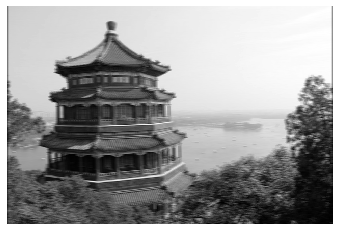

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # Vertical line
filters[3, :, :, 1] = 1 # Horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

* `images` is the input mini-batch (a 4D tensor).
* `filters` is the set of filters to apply (also a 4D tensor, as explained earlier).
* `strides` is equal to 1, but it could also be a 1D array with 4 elements, where the two central elements are vertical and horizontal strides (*sh* and *sw*). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layes's feature maps or channels).
* `padding` must be either "same" or "valid".:
    * If set to "same", the convolutional layer uses zero paddings if necasssary. In the case, the number of output neurons is equal to the number of input neurons devided to the stride, rounded up (in this example, 13/5 = 2.6, rounded up to 3). Then zeros are addedas evenly as possible around the inputs. When `strides`=1, the layes's outputs will have the same spatial dimentions (width and height) as its inputs, hance the name `same`.
    * If set to "valid", the convolutinal layer does not use zero padding, and may ignore some rows and columns at the bottom and right of the input image, depending on the stride. This means that every neuron's receptive field lies strictly within valid positions inside the input (it does not go out of bound), hance the name `valid`.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1407.png" style="width: 600px;"/>

In [3]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


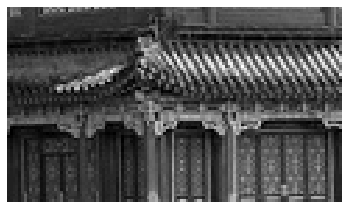

Saving figure china_vertical


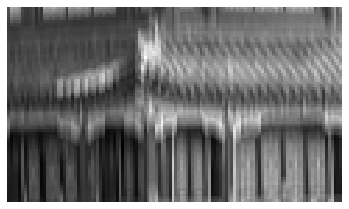

Saving figure china_horizontal


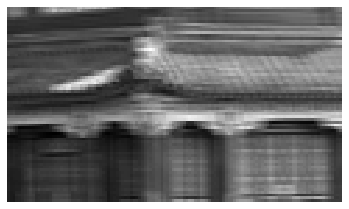

In [4]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

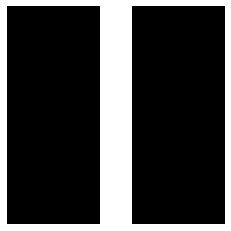

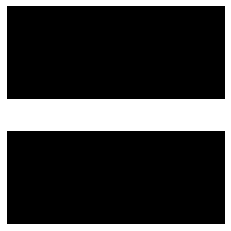

In [5]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In this example, we manually defined the filters, but in a real CNN you would normally define filters as trainable variables, so the neural net can learn which filters work best, as explained earlier. Instead of manually creating the variables, however, you can simply use the keras.layers.Conv2D layer:

In [6]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

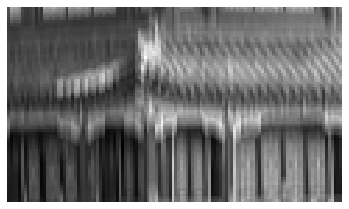

In [7]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

#### VALID vs SAME padding

In [8]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [9]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [10]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

>Using "SAME" padding is equivalent to padding manually using manual_same_padding() then using "VALID" 
padding (confusingly, "VALID" padding means no padding at all):

In [11]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

This coda creates a `Conv2D` layer with 32 filters, each 3 x 3, using a stide of 1 (both horizontally and vertically), `"same"` padding, and applying `ReLU` activation function to its outputs. As you can see, convolutinal layers have quire a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type. As always, you can use cross-validation to find the right hyperparameter values, but this is very time-consuming. 

### Memory Requirements

Another problem with CNNs is that the convolutional layers require a huge amount of RAM. This is especially true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.

For example, consider a convolutional layer with 5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and "same" padding. If the input is a 150 × 100 RGB image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 (the +1 corresponds to the bias terms), which is fairly small compared to a fully connected layer.7 However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. Not as bad as a fully connected layer, but still quite computationally intensive. Moreover, if the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM.8 And that’s just for one instance! If a training batch contains 100 instances, then this layer will use up 1.2 GB of RAM!

During inference (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.

### Pooling Layer

once you undersand how convolution layer work, the pooling layers are quite easy to gasp. Theis goal is to *subsample* (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).

Just like in convolutional layers, each euron in a pooling layer is connected to the outputs of limited number of neurons in the previous layer, located within a small rectangular receptice field. You must define its size, the ride, and the padding type, just like before. However, a pooling neuron has no weights; all it does is aggregate the inputs using ad aggregation function such as the max or mean. Common pooling layer type is `max pooling layer`. In the example, we use a 2 x 2 __pooling kernel__, with stride of 2, and no padding. Only the max input value in each receptive field makes it to next layer, while th eother inputs are dropped. For example, in the lower left receptive field in image bellow, the input values are 1, 5, 3, 2, so only the max value, 5, is propagated to next layer. Because of the stide of 2, the output image has half the height and half the weight of the input image (rounded down since we use no padding).

A pooling layer typically works on every input channel independently, so the output depth is he same as  the iput depth.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1408.png"/>

Othe than reducing cimputations, memor usege and the number of parameters, amax pooling layer also introduce some level of invariance to small translations, as show in image below. Here we assme that the bright pixels have lower value with a 2 x 2 kernel and stride 2. Image B and C are the same as image A, but shifted by one and two pixels to the right, As you can see, the outputs of max pooling layer for images A and B are identical. This is what transaltion invariance means. However, for image C the outputis defferent: it is shifted by one pixel to the right (but there is still 75% invariaance). By inserting a max pooling layer every few layer in CNN, it is possible to get some level of translation invariance at a large scale. Moreover, max pooling also offers a small amount of rotational invariance and a slight scale incariance. Such invariance (even if its limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1409.png" style="width: 600px;"/>

But max pooling has some downsides: firstly, it is obviously very destructive: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desirable, for example for semantic segmentation: this is the task of classifying each pixel in an image depending on the object that pixel belongs to: obviously, if the input image is translated by 1 pixel to the right, the output should also be translated by 1 pixel to the right. The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

### TensorFlow Implementation

Implementing a max pooling layer in TensorFlow is quite easy. The following code creates a max pooling layer using a 2 × 2 kernel. The strides default to the kernel size, so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses `"valid"` padding (i.e., no padding at all):

```
    max_pool = keras.layers.MaxPool2D(pool_size=2)
```

To create an average pooling layer, just use AvgPool2D instead of MaxPool2D. As you might expect, it works exactly like a max pooling layer, except it computes the mean rather than the max. Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest feature, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. Moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute.

Note that max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions, although this is not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern, such as hand-written digits, and the depth-wise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything else: thickness, brightness, skew, color, and so on.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1410.png" style="width: 600px;"/>

Keras does not include a depth-wise max pooling layer, but TensorFlow’s low-level Deep Learning API does: just use the tf.nn.max_pool() function, and specify the kernel size and strides as 4-tuples. The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height and width dimensions shoud be 1. The last value should be whatever kernel size and stride you want along the depth dimension, for example 3 (this must be a divisor of the input depth; for example, it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3):

```
output = tf.nn.max_pool(images,
                        ksize = (1, 1, 1, 3),
                        strides = (1, 1, 1, 3),
                        padding="valid")
```

If you want to include this as a layer in your Keras models, you can simply wrap it in a Lambda layer (or create a custom Keras layer):

```
dept_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize = (1, 1, 1, 3, strides = (1, 1, 1, 3), padding="valid"))
```

One last type of pooling layer that you will often see in modern architectures is the global average pooling layer. It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). This means that it just outputs a single number per feature map and per instance. Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer, as we will see later in this chapter. To create such a layer, simply use the keras.layers.GlobalAvgPool2D class:

```
global_avg_pool = keras.layers.GlobalAvgPool2D()
```

It is actually equivalent to this simple Lambda layer, which computes the mean over the spatial dimentions (height and width):

```
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
```

Now you know all the building blocks to create a convolutional neural network. Let’s see how to assemble them.

###### > Max Pooling

In [12]:
max_pool = keras.layers.MaxPool2D(pool_size = 2)

In [13]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)

Saving figure china_max_pooling


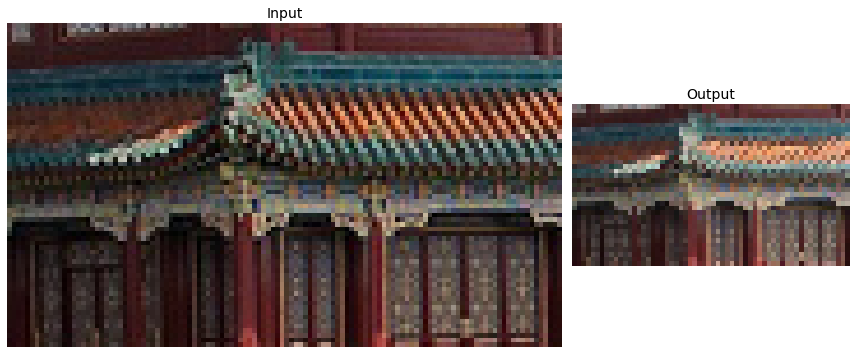

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

# Plot 1st image
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])      
ax1.axis("off")

# Plot 2nd image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

###### > Dept-Wise Polling

In [15]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize=(1, 1, 1, self.pool_size),
                             strides=(1, 1, 1, self.pool_size),
                             padding=self.padding)

In [16]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [17]:
####### Using lambda layer
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

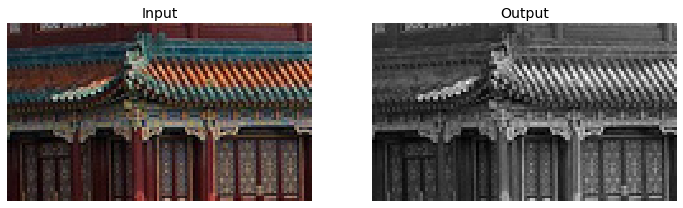

In [18]:
plt.figure(figsize=(12, 8))
# Plot 1st image
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
# Plot 1st image output
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

###### > Average Pooling

In [19]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [20]:
output_avg = avg_pool(cropped_images)

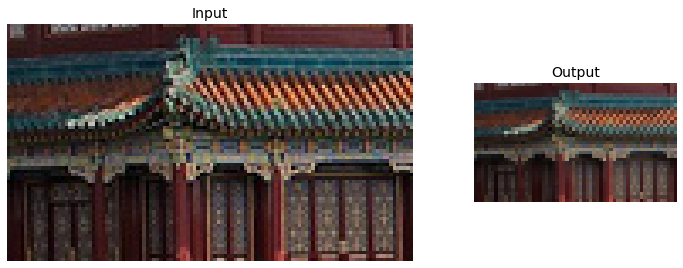

In [21]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

###### > Global Average Pooling

In [22]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=122, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45952241, 0.33423483]])>

In [23]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=126, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45952241, 0.33423483]])>

###  CNN Architectures

Typical CNN architecrutes stack a few convolutional layers (each line generally followed by ReLU layer),then a pooling lyaer, then another few convolutional layers (+ReLU), then another pooling layer, and so on.The image gets smaller and smaller as it progresses through the network, bit it alsoo typically gets deeper and deeper (i.e., with more feature maps). At the top of the stack, a regular feed forward neural network is added, composed of few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1411.png"/>

Here is how you can implement a simple CNN to tackle the Fashion MNIST dataset:

```
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
```

* The first layer uses 64 fairly large filters (7 x 7), but no stride because the input images are not very large. It also sets `input_shape=[28, 28, 1]`, because the images are 28 x 28 pixels, with a single color channel (i.e., grayscale).

* Next, we have a max pooling layer, which uses a pool size of 2, so it divides each spatioal dimention by 2.

* Then we repeat the same structure twice: two convolution layers followed by a max pooling layer. For larger mages, we could repeat this structure several more times (the number of repetations is a hyperparameter you can tune).

* Note that the number of filters grows as we climb up the CNN towards the output layer (it is initialy 64, then 128m then 256): it makes sense for it to grow, since the number of low level features is often fairly low (e.g., small circle, horizontal lines, etc.), but there are many different way to combine them into higer level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimention by a factor of 2, we can afford doubling the number of feature maps in the next layer, without fear of exploding the number of parameters, memory usage, or computational load.

* Next is the fully connected network, composed of 2 hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. we also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

###### > Tackling Fashion MNIST with a CNN

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)

# Predict new image
X_new = X_test[:10] 
y_pred = model.predict(X_new)

W0705 10:39:41.315606  4692 deprecation.py:323] From c:\users\babyanaconda\anaconda3\envs\babytf_gpu\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0705 10:39:41.929935  4692 deprecation.py:323] From c:\users\babyanaconda\anaconda3\envs\babytf_gpu\lib\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 90s 2ms/sample - loss: 0.7106 - accuracy: 0.7506 - val_loss: 0.3791 - val_accuracy: 0.8692
Epoch 2/10
55000/55000 [==============================] - 133s 2ms/sample - loss: 0.4221 - accuracy: 0.8567 - val_loss: 0.3121 - val_accuracy: 0.8846
Epoch 3/10
55000/55000 [==============================] - 152s 3ms/sample - loss: 0.3631 - accuracy: 0.8778 - val_loss: 0.2996 - val_accuracy: 0.8950
Epoch 4/10
55000/55000 [==============================] - 145s 3ms/sample - loss: 0.3311 - accuracy: 0.8879 - val_loss: 0.2957 - val_accuracy: 0.8926
Epoch 5/10
55000/55000 [==============================] - 150s 3ms/sample - loss: 0.3117 - accuracy: 0.8932 - val_loss: 0.2926 - val_accuracy: 0.8954
Epoch 6/10
55000/55000 [==============================] - 149s 3ms/sample - loss: 0.2934 - accuracy: 0.9011 - val_loss: 0.2765 - val_accuracy: 0.8992
Epoch 7/10
55000/55000 [============================

#### LeNet-5

The LeNet-5 architecture10 is perhaps the most widely known CNN architecture. As mentioned earlier, it was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST). It is composed of the layers shown in Table below.

<table id="alexnet_architecture">
    <caption>LeNet-5 architecture</caption>
    <thead>
        <tr>
            <th>Layer</th>
            <th>Type</th>
            <th>Maps</th>
            <th>Size</th>
            <th>Kernel size</th>
            <th>Stride</th>
            <th>Padding</th>
            <th>Activation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <p>Out</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>1,000</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>Softmax</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>F9</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>4,096</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>F8</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>4,096</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C7</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C6</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>384</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C5</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>384</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>S4</p>
            </td>
            <td>
                <p>Max Pooling</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>2</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C3</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>27 × 27</p>
            </td>
            <td>
                <p>5 × 5</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>S2</p>
            </td>
            <td>
                <p>Max Pooling</p>
            </td>
            <td>
                <p>96</p>
            </td>
            <td>
                <p>27 × 27</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>2</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C1</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>96</p>
            </td>
            <td>
                <p>55 × 55</p>
            </td>
            <td>
                <p>11 × 11</p>
            </td>
            <td>
                <p>4</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>In</p>
            </td>
            <td>
                <p>Input</p>
            </td>
            <td>
                <p>3 (RGB)</p>
            </td>
            <td>
                <p>227 × 227</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
    </tbody>
</table>

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.

* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps).

* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

##### AlexNet

The AlexNet CNN architecture11 won the 2012 ImageNet ILSVRC challenge by a large margin: it achieved 17% top-5 error rate while the second best achieved only 26%! It was developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer.

<table id="alexnet_architecture">
    <caption>AlexNet architecture</caption>
    <thead>
        <tr>
            <th>Layer</th>
            <th>Type</th>
            <th>Maps</th>
            <th>Size</th>
            <th>Kernel size</th>
            <th>Stride</th>
            <th>Padding</th>
            <th>Activation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <p>Out</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>1,000</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>Softmax</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>F9</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>4,096</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>F8</p>
            </td>
            <td>
                <p>Fully Connected</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>4,096</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C7</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C6</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>384</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C5</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>384</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>S4</p>
            </td>
            <td>
                <p>Max Pooling</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>13 × 13</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>2</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C3</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>256</p>
            </td>
            <td>
                <p>27 × 27</p>
            </td>
            <td>
                <p>5 × 5</p>
            </td>
            <td>
                <p>1</p>
            </td>
            <td>
                <p>same</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>S2</p>
            </td>
            <td>
                <p>Max Pooling</p>
            </td>
            <td>
                <p>96</p>
            </td>
            <td>
                <p>27 × 27</p>
            </td>
            <td>
                <p>3 × 3</p>
            </td>
            <td>
                <p>2</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>C1</p>
            </td>
            <td>
                <p>Convolution</p>
            </td>
            <td>
                <p>96</p>
            </td>
            <td>
                <p>55 × 55</p>
            </td>
            <td>
                <p>11 × 11</p>
            </td>
            <td>
                <p>4</p>
            </td>
            <td>
                <p>valid</p>
            </td>
            <td>
                <p>ReLU</p>
            </td>
        </tr>
        <tr>
            <td>
                <p>In</p>
            </td>
            <td>
                <p>Input</p>
            </td>
            <td>
                <p>3 (RGB)</p>
            </td>
            <td>
                <p>227 × 227</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
            <td>
                <p>–</p>
            </td>
        </tr>
    </tbody>
</table>

To reduce overfitting, the authors used two regularization techniques: first they applied dropout with a 50% dropout rate during training to the outputs of layers F8 and F9. Second, they performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

AlexNet also uses a competitive normalization step immediately after the ReLU step of layers C1 and C3, called `local response normalization`. The most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps (such competitive activation has been observed in biological neurons). This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.

![image](https://user-images.githubusercontent.com/38347258/60643942-e190fa00-9e5e-11e9-868b-e26250da82a0.png)

* `bi` is the normalized output of the neuron located in feature map `i`, at some row `u` and column `v `(note that in this equation we consider only neurons located at this row and column, so `u` and `v` are not shown).

* `ai` is the activation of that neuron after the `ReLU` step, but before normalization.

* `k, α, β, and r` are hyperparameters. `k` is called the `bias`, and `r` is called the `depth radius`.

* `fn` is the number of feature maps.

For example, if r = 2 and a neuron has a strong activation, it will inhibit the activation of the neurons located in the feature maps immediately above and below its own.

In AlexNet, the hyperparameters are set as follows: r = 2, α = 0.00002, β = 0.75, and k = 1. This step can be implemented using the tf.nn.local_response_normalization() function (which you can wrap in a Lambda layer if you want to use it in a Keras model).

A variant of AlexNet called `ZF Net` was developed by Matthew Zeiler and Rob Fergus and won the 2013 ILSVRC challenge. It is essentially AlexNet with a few tweaked hyperparameters (number of feature maps, kernel size, stride, etc.).

##### GoogLeNet

The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research, and it won the ILSVRC 2014 challenge by pushing the top-5 error rate below 7%. This great performance came in large part from the fact that the network was much deeper than previous CNNs. This was made possible by sub-networks called inception modules, which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

Image below shows the architecture of an inception module. The notation “3 × 3 + 1(S)” means that the layer uses a 3 × 3 kernel, stride 1, and "same" padding. The input signal is first copied and fed to four different layers. All convolutional layers use the `ReLU` activation function. Note that the second set of convolutional layers uses different kernel sizes (1 × 1, 3 × 3, and 5 × 5), allowing them to capture patterns at different scales. Also note that every single layer uses a stride of 1 and "same" padding (even the max pooling layer), so their outputs all have the same height and width as their inputs. This makes it possible to concatenate all the outputs along the depth dimension in the final depth concat layer (i.e., stack the feature maps from all four top convolutional layers). This concatenation layer can be implemented in TensorFlow using the `tf.concat()` operation, with axis=3 (axis 3 is the depth).

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1413.png" style="width:600px;"/>

You may wonder why inception modules have convolutional layers with 1 × 1 kernels. Surely these layers cannot capture any features since they look at only one pixel at a time? In fact, these layers serve three purposes:

* First, although they cannot capture spatial patterns, they can capture patterns along the depth dimension.

* Second, they are configured to output fewer feature maps than their inputs, so they serve as bottleneck layers, meaning they reduce dimensionality. This cuts the computational cost and the number of parameters, speeding up training and improving generalization.

* Lastly, each pair of convolutional layers ([1 × 1, 3 × 3] and [1 × 1, 5 × 5]) acts like a single, powerful convolutional layer, capable of capturing more complex patterns. Indeed, instead of sweeping a simple linear classifier across the image (as a single convolutional layer does), this pair of convolutional layers sweeps a two-layer neural network across the image.

Now let’s look at the architecture of the GoogLeNet CNN below. The number of feature maps output by each convolutional layer and each pooling layer is shown before the kernel size. The architecture is so deep that it has to be represented in three columns, but GoogLeNet is actually one tall stack, including nine inception modules (the boxes with the spinning tops). The six numbers in the inception modules represent the number of feature maps output by each convolutional layer in the module (in the same order as in above). Note that all the convolutional layers use the ReLU activation function.

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_1414.png" style="width:600px;"/>

Let’s go through this network:

* The first two layers divide the image’s height and width by 4 (so its area is divided by 16), to reduce the computational load. The first layer uses a large kernel size, so that much of the information is still preserved.

* Then the local response normalization layer ensures that the previous layers learn a wide variety of features (as discussed earlier).

* Two convolutional layers follow, where the first acts like a bottleneck layer. As explained earlier, you can think of this pair as a single smarter convolutional layer.

* Again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns.

* Next a max pooling layer reduces the image height and width by 2, again to speed up computations.

* Then comes the tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality and speed up the net.

* Next, the global average pooling layer simply outputs the mean of each feature map: this drops any remaining spatial information, which is fine since there was not much spatial information left at that point. Indeed, GoogLeNet input images are typically expected to be 224 × 224 pixels, so after 5 max pooling layers, each dividing the height and width by 2, the feature maps are down to 7 × 7. Moreover, it is a classification task, not localization, so it does not matter where the object is. Thanks to the dimensionality reduction brought by this layer, there is no need to have several fully connected layers at the top of the CNN (like in AlexNet), and this considerably reduces the number of parameters in the network and limits the risk of overfitting.

* The last layers are self-explanatory: dropout for regularization, then a fully connected layer with 1,000 units, since there are a 1,000 classes, and a softmax activation function to output estimated class probabilities.

##### VGGNet

The runner up in the ILSVRC 2014 challenge was VGGNet, developed by K. Simonyan and A. Zisserman from the Visual Geometry Group (VGG) research lab at Oxford University. It had a very simple and classical architecture, with 2 or 3 convolutional layers, a pooling layer, then again 2 or 3 convolutional layers, a pooling layer, and so on (with a total of just 16 or 19 convolutional layers, depending on the VGG variant), plus a final dense network with 2 hidden layers and the output layer. It used only 3 × 3 filters, but many filters.

### Using Pretrained Model From Keras

In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code, in the keras.applications package. For example:
``` 
model = keras.applications.resnet50.Resnet50(weights="imagenet")
```
That’s all! This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. To use it, you first need to ensure that the images have the right size. A ResNet-50 model expects 224 × 224 images (other models may expect other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function to resize the images we loaded earlier:
```
images_resized = tf.image.resize(images, [224, 224])
```

> Note:
>>The tf.image.resize() will not preserve the aspect ratio. If this is a problem, you can try cropping the images to the appropriate aspect ratio before resizing. Both operations can be done in one shot with tf.image.crop_and_resize().

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or -1 to 1, and so on. Each model provides a `preprocess_input()` function that you can use to preprocess your images. These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

```
inputs = keras.application.resnet50.preprocess_input(image_resized * 255)
```
Now we can use pretrained model to make predictions:
```
Y_proba = model.predict(inputs)
```
As usual, the output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, you can use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier, its name and the corresponding confidence score:
```
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()
```
The correct classes (monastery and daisy) appear in the top 3 results for both images. That’s pretty good considering that the model had to choose among 1,000 classes.

As you can see, it is very easy to create a pretty good image classifier using a pretrained model. Other vision models are available in keras.applications, including several ResNet variants, GoogLeNet variants like InceptionV3 and Xception, VGGNet variants, MobileNet and MobileNetV2 (lightweight models for use in mobile applications), and more.

But what if you want to use an image classifier for classes of images that are not part of ImageNet? In that case, you may still benefit from the pretrained models to perform transfer learning.

### Pretrained Model for Transfer Learning

If you want to build an image classifier, but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model. For example. let's train a model to classify picture of flowers, reusing a pretrained Xception model. First, let's load the dataset using TensorFlow Datasets:
```
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, width_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5
```
Note that you can get information about the dataset by setting with_info=True. Here, we get the dataset size and the names of the classes. Unfortunately, there is only a "train" dataset, no test set or validation set, so we need to split the training set. The TF Datasets project provides an API for this. For example, let’s take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:
```
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)
```
Next we must preprocess the images. The CNN expects 224 × 224 images, so we need to resize them. We also need to run the image through Xception’s preprocess_input() function:
```
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label
```
Let's apply this preprocessing function to all 3 datasets, and let's also shuffle the training set, and add bathing and prefetching to all datasets:
```
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)
```
If you want to perform some data augmentation, you can just change the preprocessing function for the training set, adding some random transformations to the training images. For example, use `tf.image.random_crop()` to randomly crop the images, use `tf.image.random_flip_left_right()` to randomly flip the images horizontally, and so on (see the notebook for an example).

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network (by setting `include_top=False`): this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with 1 unit per class, using the softmax activation function. Finally, we create the Keras Model:
```
base_model = keras.appliacations.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classses, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)
```

It's usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training:
```
for layer in base_model.layers:
    layer.trainable = False
```
Finally, we can compile the model and start training:
```
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, matrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)
```
After training the model for a few epochs, its validation accuracy should reach about 75-80%, and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all layers (or you could try unfreezing just the top ones), and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights:
```
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(...)
history = model.fit(...)
```